In [1]:
import os
from glob import glob
import earthpy.plot as ep

In [2]:
import gdal
import statistics
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
import rasterio
import sys

In [5]:
def saveImage(src, savePath, arr):
    with rasterio.Env():
        profile = src.profile
        profile.update(
            dtype=rasterio.float64,
            count=1)
        with rasterio.open(savePath, 'w', **profile) as dst:
            dst.write(arr.astype(rasterio.float64), 1)

In [6]:
def filterCluster(clusters, num, ndvi_orig, empty):
    cls = np.where(clusters == num, ndvi_orig, empty)
    minimum = np.nanmin(cls)
    maximum = np.nanmax(cls)
    return [num, minimum, maximum]

In [7]:
#def getClusterBounds(clusters):
#    sparse_low = 0
#    for date in clusters:
#        sparse_low = sparse_low + date[2][1]
#    sparse_low = sparse_low / len(clusters)
#    sparse_up = 0
#    for date in clusters:
#        sparse_up = sparse_up + date[3][1]
#    sparse_up = sparse_up / len(clusters)
#    return [sparse_low, sparse_up]


def getClusterBounds(clusters):
    sparse_low = []
    for date in clusters:
        sparse_low.append(date[1][1])
    sparse_low = statistics.median(sparse_low)
    sparse_up = []
    for date in clusters:
        sparse_up.append(date[2][1])
    sparse_up = statistics.median(sparse_up)
    return [sparse_low, sparse_up]

In [8]:
working_clusters = os.getcwd() + "\\working_clusters\\Godavari"
working_ndvi = os.getcwd() + "\\working_ndvi\\Godavari"
if not os.path.exists(working_clusters):
    os.mkdir(working_clusters)
if not os.path.exists(working_ndvi):
    os.mkdir(working_ndvi)

In [9]:
path = os.getcwd()
path = path + "\\ndvi_images"
orig_scenes = glob(path+"\\Godavari*.tif")
orig_scenes

['C:\\Users\\Hello\\Documents\\remote-sensing\\APIs\\SentinelSat\\ndvi_images\\Godavari20180225.tif',
 'C:\\Users\\Hello\\Documents\\remote-sensing\\APIs\\SentinelSat\\ndvi_images\\Godavari20190215.tif']

In [10]:
data = os.getcwd() + "\\rsgislib_clusters"
scenes = glob(data+"\\Godavari*_sub_five_clusters_ndvi.tif")
scenes

['C:\\Users\\Hello\\Documents\\remote-sensing\\APIs\\SentinelSat\\rsgislib_clusters\\Godavari20180225_sub_five_clusters_ndvi.tif',
 'C:\\Users\\Hello\\Documents\\remote-sensing\\APIs\\SentinelSat\\rsgislib_clusters\\Godavari20190215_sub_five_clusters_ndvi.tif']

In [11]:
date_bands = {}
for i in range(len(orig_scenes)):
    date = orig_scenes[i].split('\\')[-1].split('.')[0]
    ndvi_image = gdal.Open(orig_scenes[i])
    ndvi_orig = np.array(ndvi_image.GetRasterBand(1).ReadAsArray())
    clustered_image = gdal.Open(scenes[i])
    clusters = np.array(clustered_image.GetRasterBand(1).ReadAsArray())
    band_values = []
    for num in range(1,6):
        band_values.append(filterCluster(clusters, num, ndvi_orig, np.nan))
    date_bands[date] = band_values
    print(date)
    for band in band_values:
        print(band)
#print(date_bands)

Godavari20180225
[1, 0.5426128773710928, 0.7235399132874267]
[2, 0.015610651974288337, 0.29601460298144205]
[3, 0.29601518026565465, 0.5426127015465614]
[4, 0.723540731237973, 0.8625719769673704]
[5, -0.6267696267696268, 0.015609756097560976]
Godavari20190215
[1, 0.7469544030630003, 0.9995544664736021]
[2, 0.2202599133622126, 0.5024330900243309]
[3, -1.0, -0.1989041095890411]
[4, 0.5024334383051818, 0.746954076850984]
[5, -0.19890260631001372, 0.22025912838633688]


In [12]:
print(date_bands.keys())

dict_keys(['Godavari20180225', 'Godavari20190215'])


In [13]:
def sortClusters(clusters):
    for i in range(len(clusters)):
        clusters[i] = sorted(clusters[i])
    clusters = sorted(clusters)
    return clusters

In [14]:
clusters = []
for item in date_bands.keys():
    date_bands[item] = sortClusters(date_bands[item])
    print(date_bands[item])
    clusters.append(date_bands[item])

[[-0.6267696267696268, 0.015609756097560976, 5], [0.015610651974288337, 0.29601460298144205, 2], [0.29601518026565465, 0.5426127015465614, 3], [0.5426128773710928, 0.7235399132874267, 1], [0.723540731237973, 0.8625719769673704, 4]]
[[-1.0, -0.1989041095890411, 3], [-0.19890260631001372, 0.22025912838633688, 5], [0.2202599133622126, 0.5024330900243309, 2], [0.5024334383051818, 0.746954076850984, 4], [0.7469544030630003, 0.9995544664736021, 1]]


In [15]:
bounds = getClusterBounds(clusters)
print(bounds)

[0.2581368656838895, 0.5225228957854462]


In [16]:
def imMap(date, ndvi, col):
    ep.plot_bands(ndvi, 
        cmap=col,
        scale=False,
        title=date)
    plt.show()

In [17]:
def hist(date, ndvi):
    ep.hist(ndvi,
            figsize=(12, 6),
            title=[date])
    plt.show()

In [18]:
def filterImageBounds(date, bounds):
    orig_scene = os.getcwd() + "\\ndvi_images\\" + date + ".tif"
    ndvi_image = gdal.Open(orig_scene)
    ndvi_orig_data = np.array(ndvi_image.GetRasterBand(1).ReadAsArray())
    
    ndvi_orig_data = np.where(ndvi_orig_data < bounds[0], np.nan, ndvi_orig_data)
    
    cluster_scene_data = np.copy(ndvi_orig_data)
    cluster_scene_data = np.where(cluster_scene_data > bounds[1], -1, cluster_scene_data)
    cluster_scene_data = np.where(cluster_scene_data >= bounds[0], 1, cluster_scene_data)
    
    #imMap(date, ndvi_orig_data, "Greens")
    imMap(date, cluster_scene_data, "Spectral")
    hist(date, ndvi_orig_data)
    hist(date, cluster_scene_data)
    #imMap(date, np.where(ndvi_orig_data > bounds[1], np.nan, ndvi_orig_data))
    #hist(date, np.where(ndvi_orig_data > bounds[1], np.nan, ndvi_orig_data))
    saveImage(rasterio.open(orig_scene), working_ndvi + "\\" + date + ".tif", ndvi_orig_data)
    saveImage(rasterio.open(orig_scene), working_clusters + "\\" + date + ".tif", cluster_scene_data)

Godavari20180225


C:\Users\Hello\.conda\envs\pro\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  
C:\Users\Hello\.conda\envs\pro\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
C:\Users\Hello\.conda\envs\pro\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater_equal
  # Remove the CWD from sys.path while we load stuff.


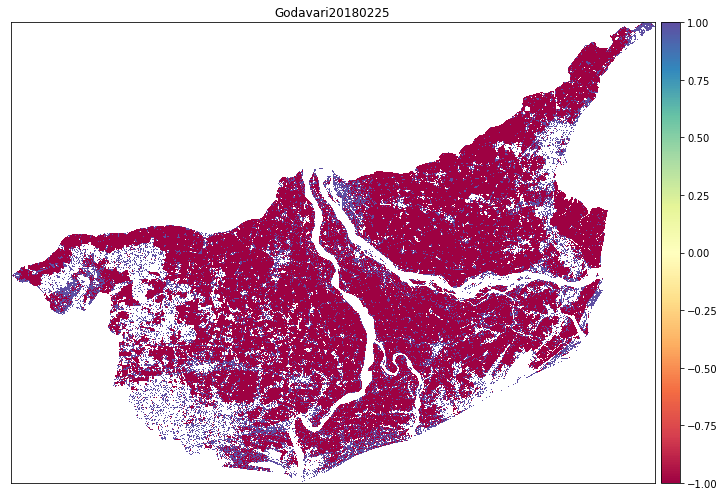

C:\Users\Hello\.conda\envs\pro\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Hello\.conda\envs\pro\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


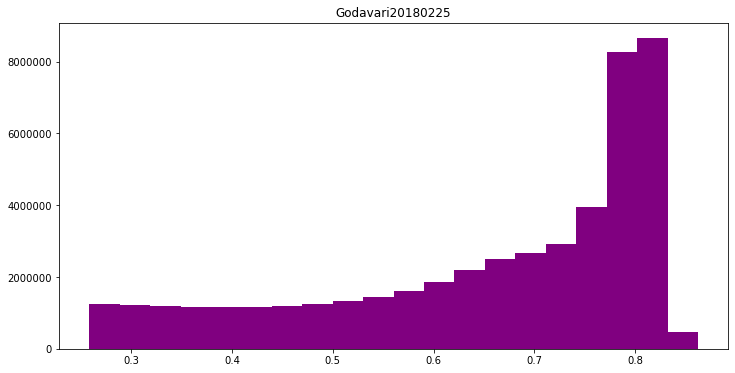

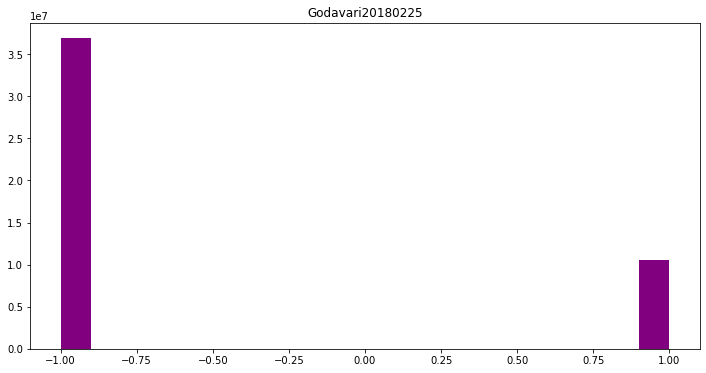

Godavari20190215


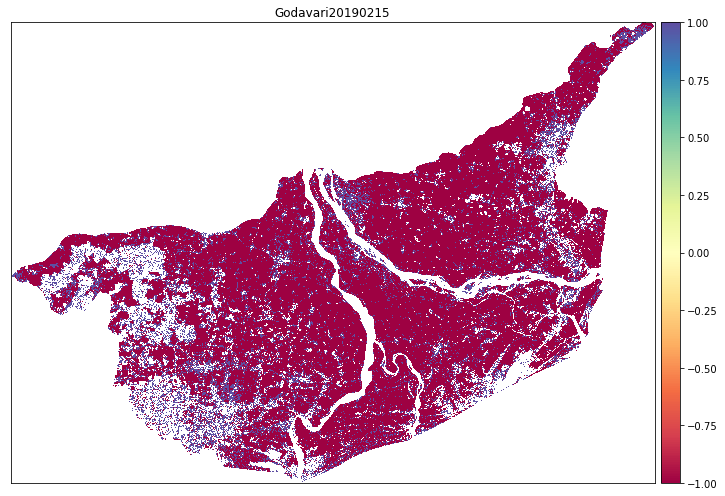

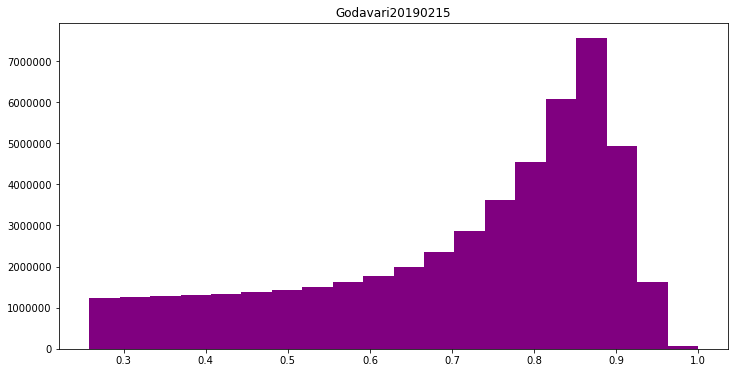

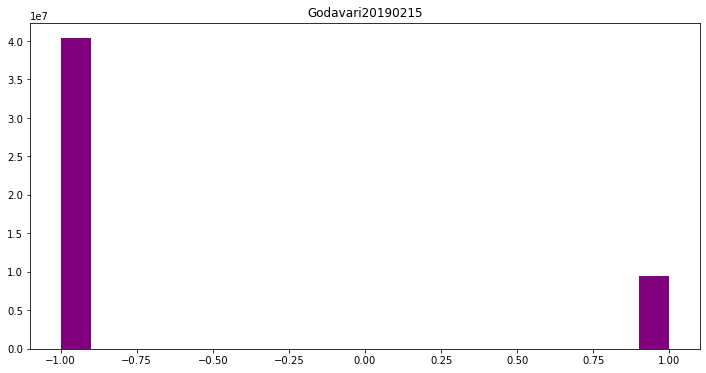

In [19]:
for item in date_bands.keys():
    print(item)
    filterImageBounds(item, bounds)